In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kf_book.book_plots as book_plots
import math
from numpy.random import randn

## Newton's Equations of Motion

Newton's equations of motion tells us that given a constant velocity $v$ of a system we can compute its position $x$ after time $t$ with:

$$x = vt + x_0$$
For example, if we start at position 13, our velocity is 10 m/s, and we travel for 12 seconds our final position is 133 ($10\times 12 + 13$).

We can incorporate constant acceleration with this equation

$$x = \frac{1}{2}at^2 + v_0t + x_0$$
And if we assume constant jerk we get

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$
These equations were generated by integrating a differential equation. Given a constant velocity v we can compute the distance traveled over time with the equation

$$x = vt + x_0$$
which we can derive with

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$
When you design a Kalman filter you start with a system of differential equations that describe the dynamics of the system. Most systems of differential equations do not easily integrate in this way. We start with Newton's equation because we can integrate and get a closed form solution, which makes the Kalman filter easier to design. An added benefit is that Newton's equations are the right equations to use to track moving objects, one of the main uses of Kalman filters.

## Kalman Filter Algorithm
The algorithm is the same Bayesian filter algorithm that we have used in every chapter. The update step is slightly more complicated, but I will explain why when we get to it.

Initialization

1. Initialize the state of the filter
2. Initialize our belief in the state

Predict

1. Use process model to predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction    
Update

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. Compute scaling factor based on whether the measurement
or prediction is more accurate
4. set state between the prediction and measurement based 
on scaling factor
5. update belief in the state based on how certain we are 
in the measurement

As a reminder, here is a graphical depiction of the algorithm:

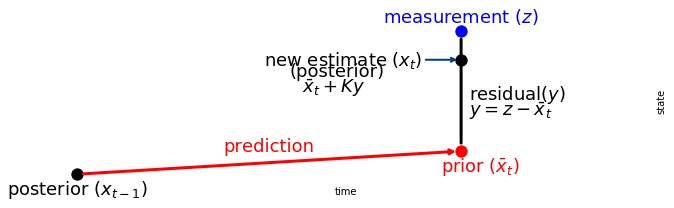

In [2]:
book_plots.show_residual_chart()

The univariate Kalman filter represented the state with a univariate Gaussian. Naturally the multivariate Kalman filter will use a multivariate Gaussian for the state.

The equations are similar:

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\ \hline
\end{array}$

Without worrying about the specifics of the linear algebra, we can see that:

$\mathbf x,\, \mathbf P$ are the state mean and covariance. They correspond to $x$ and $\sigma^2$.

$\mathbf F$ is the state transition function. When multiplied by $\bf x$ it computes the prior.

$\mathbf Q$ is the process covariance. It corresponds to $\sigma^2_{f_x}$.

$\mathbf B$ and $\mathbf u$ are new to us. They let us model control inputs to the system.

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ is the measurement function. We haven't seen this yet in this book and I'll explain it later. If you mentally remove $\mathbf H$ from the equations, you should be able to see these equations are similar as well.

$\mathbf z,\, \mathbf R$ are the measurement mean and noise covariance. They correspond to $z$ and $\sigma_z^2$ in the univariate filter (I've substituted $\mu$ with $x$ for the univariate equations to make the notation as similar as possible).

$\mathbf y$ and $\mathbf K$ are the residual and Kalman gain.

The details will be different than the univariate filter because these are vectors and matrices, but the concepts are exactly the same:

* Use a Gaussian to represent our estimate of the state and error
* Use a Gaussian to represent the measurement and its error
* Use a Gaussian to represent the process model
* Use the process model to predict the next state (the prior)
* Form an estimate part way between the measurement and the prior

Your job as a designer will be to design the state $\left(\mathbf x, \mathbf P\right)$, the process $\left(\mathbf F, \mathbf Q\right)$, the measurement $\left(\mathbf z, \mathbf R\right)$, and the measurement function $\mathbf H$. If the system has control inputs, such as a robot, you will also design $\mathbf B$ and $\mathbf u$.

## Tracking a Dog

We start by writing a simulation for the dog. The simulation will run for count steps, moving the dog forward approximately 1 meter for each step. At each step the velocity will vary according to the process variance ```process_var```. After updating the position we compute a measurement with an assumed sensor variance of ```z_var```. The function returns an NumPy array of the positions and another of the measurements.

In [3]:
def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

## 1. Predict Step
For the prediction we need to design the state and covariance, the process model and the process noise, and optionally the control input.

### Design State Variable

We will be tracking both the position and velocity of the dog. This requires us to use a multivariate Gaussian represented with the state vector $\mathbf x$ and its corresponding covariance matrix $\mathbf P$.

State variables can either be *observed variables* - directly measured by a sensor, or *hidden variables* - inferred from the observed variables. For our dog tracking problem the sensor only reads position, so position is observed and velocity is hidden.

 For example, if we wanted to specify a position of 10.0 m and a velocity of 4.5 m/s, we would write:

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$
The Kalman filter is implemented using linear algebra. We use an $n\times 1$ matrix (called a vector) to store  $n$ state variables. For the dog tracking problem, we use $x$ to denote position, and the first derivative of $x$, $\dot x$, for velocity. I use Newton's dot notation for derivatives; $\dot x$ represents the first derivative of x with respect to t: $\dot x = \frac{dx}{dt}$. Kalman filter equations use $\mathbf x$ for the state, so we define $\mathbf x$ as:

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$
We use $\mathbf x$ instead of $\mu$, but recognize this is the mean of the multivariate Gaussian.

Another way to write this is $\mathbf x =\begin{bmatrix}x &amp; \dot x\end{bmatrix}^\mathsf T$ because the transpose of a row vector is a column vector. This notation is easier to use in text because it takes less vertical space.

$\mathbf x$ and the position $x$ coincidentally have the same name. If we were tracking the dog in the y-axis we would write $\mathbf x =\begin{bmatrix}y &amp; \dot y\end{bmatrix}^\mathsf T$, not $\mathbf y =\begin{bmatrix}y &amp; \dot y\end{bmatrix}^\mathsf T$. $\mathbf x$ is the standard name for the state variable used in the Kalman filter literature and we will not vary it to give it a more meaningful name. This consistency in naming allows us to communicate with our peers.

Let's code this. Initialization of x is as simple as

In [4]:
x = np.array([[1000.0],
              [4.5]])
x

array([[1000. ],
       [   4.5]])

I often use the transpose in my code to turn a row matrix into a column vector, as I find it easier to type and read:

In [5]:
x = np.array([[10., 4.5]]).T
x

array([[10. ],
       [ 4.5]])

However, NumPy recognizes 1D arrays as vectors, so I can simplify this line to use a 1D array.

In [6]:
x = np.array([10.0, 4.5])
x

array([10. ,  4.5])

All of the array elements have the same type, typically either ```float``` or ```int```. If the list contains all ints then the created array will also have a data type of ```int```, otherwise it will be ```float```. I will often take advantage of this by only specifying one number as a floating point:

In [7]:
np.array([1., 0, 0, 0, 0, 0])

array([1., 0., 0., 0., 0., 0.])

Here are some examples.

In [8]:
A = np.array([[1, 2], [3, 4]])
x = np.array([[10.0], [4.5]])

In [9]:
# matrix multiply
print(np.dot(A, x))
print()

[[19.]
 [48.]]



In [10]:
x = np.array([[10.0, 4.5]]).T
print(np.dot(A, x))
print()

[[19.]
 [48.]]



In [11]:
x = np.array([10.0, 4.5])
print(np.dot(A, x))

[19. 48.]


### Design State Covariance

We specify an initial value for $\mathbf P$ and the filter updates it during each epoch.

We need to set the variances to reasonable values. For example, we may choose $\sigma_\mathtt{pos}^2=500 m^2$ if we are quite uncertain about the initial position. Top speed for a dog is around 21 m/s, so in the absence of any other information about the velocity we can set $3\sigma_\mathtt{vel}=21$, or $\sigma_\mathtt{vel}^2=7^2=49$.

We know that the position and velocities are correlated. But how correlated are they for a dog? I have no idea. As we will see the filter computes this for us, so I initialize the covariances to zero. Of course, if you know the covariances you should use them.

Recall that the diagonals of the covariance matrix contains the variance of each variable, and the off-diagonal elements contains the covariances. Thus we have:

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$
We can use ```numpy.diag```, which creates a diagonal matrix from the values for the diagonal. Recall from linear algebra that a diagonal matrix is one with zeros in the off-diagonal elements.

In [12]:
P = np.diag([500., 49.])
P

array([[500.,   0.],
       [  0.,  49.]])

I could have written:

In [13]:
P = np.array([[500., 0.],
              [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

### Design the Process Model
The filter uses it to predict the state after a discrete time step. We do this with a set of equations that describe the dynamics of the system.

Linear algebra has a powerful way to express systems of equations. Take this system

$$\begin{cases}
2x+3y=8\\4x-y=2
\end{cases}$$

We can put this in matrix form by writing:

$$\begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\2\end{bmatrix}$$
If you perform the matrix multiplication in this equation the result will be the two equations above. In linear algebra we would write this as $\mathbf{Ax}=\mathbf B$, where

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4& -1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf B=\begin{bmatrix}8\\2\end{bmatrix}$$
And then we can use the SciPy's linalg package to solve for $\mathbf x$:

In [14]:
from scipy.linalg import solve
A = np.array([[2, 3],[4, -1]])
b = np.array([[8], [2]])
x = solve(A, b)
x

array([[1.],
       [2.]])

Kalman filters implement this using this linear equation, where $\mathbf{\bar x}$ is the prior, or predicted state:

$$\mathbf{\bar x} = \mathbf{Fx}$$
which we can make explicit as

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$
Our job as Kalman filters designers is to specify $\mathbf F$ such that $\bar{\mathbf x}  = \mathbf{Fx}$ performs the innovation (prediction) for our system. To do this we need one equation for each state variable. In our problem $\mathbf x = \begin{bmatrix}x & \dot x\end{bmatrix}^\mathtt{T}$, so we need one equation to compute the position $x$ and another to compute the velocity $\dot x$ . We already know the equation for the position innovation:

$$\bar x = x + \dot x \Delta t$$
What is our equation for velocity? We have no predictive model for how our dog's velocity will change over time. In this case we assume that it remains constant between innovations. Of course this is not exactly true, but so long as the velocity doesn't change too much over each innovation you will see that the filter performs very well. So we say

$$\bar{\dot x} = \dot x$$
This gives us the process model for our system

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} & = \dot x
\end{aligned}
\end{cases}$$
This correctly has one equation for each variable in the state, isolated on the left hand side. We need to express this set of equations in the form $\bar{\mathbf x}  = \mathbf{Fx}$. Rearranging terms makes it easier to see what to do.

$$\begin{cases}
\begin{aligned}
\bar x & = 1x + & \Delta t\, \dot x \\
\bar{\dot x} & =0x + & 1\, \dot x
\end{aligned}
\end{cases}$$
We can rewrite this in matrix form as

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1& \Delta t  \\ 0& 1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$
$\mathbf F$ is called the *state transition function* or the *state transition matrix*. In later chapters it will be a true function, not a matrix, so calling it a function is a bit more general.

In [15]:
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

FilterPy has a ```predict``` method that performs the prediction by computing $\mathbf{\bar x} = \mathbf{Fx}$. Let's call it and see what happens. We've set the position to 10.0 and the velocity to 4.5 meter/sec. We've defined ```dt = 0.1```, which means the time step is 0.1 seconds, so we expect the new position to be 10.45 meters after the innovation. The velocity should be unchanged.

In [16]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [10.45  4.5 ]


This worked. If we call predict() several times in a row the value will be updated each time.

In [17]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x =', x)

x = [10.9  4.5]
x = [11.35  4.5 ]
x = [11.8  4.5]
x = [12.25  4.5 ]


```predict()``` computes both the mean and covariance of the innovation. This is the value of $\mathbf P$ after five innovations (predictions), which we denote $\mathbf{\bar P}$ in the Kalman filter equations.

In [18]:
print(P)

[[512.25  24.5 ]
 [ 24.5   49.  ]]


Inspecting the diagonals shows us that the position variance got larger. We've performed five prediction steps with no measurements, and our uncertainty grew. The off-diagonal elements became non-zero - the Kalman filter detected a correlation between position and velocity! The variance of the velocity did not change.

Here I plot the covariance before and after the prediction. The initial value is in solid red, and the prior (prediction) is in dashed black. I've altered the covariance and time step to better illustrate the change.

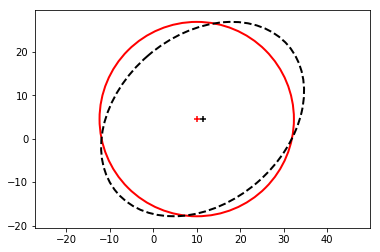

In [19]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

You can see that the center of the ellipse shifted by a small amount (from 10 to 10.90) because the position changed. The ellipse also elongated, showing the correlation between position and velocity.

### Design Process Noise

We can model this system with the differential equation

$$\dot{\mathbf x} = f(\mathbf x) + w$$
where $f(\mathbf x)$ models the state transition and $w$ is white process noise.

Deriving the process noise matrix can be quite demanding, and we will put it off until the Kalman math chapter. For now know that $\mathbf Q$ equals the expected value of the white noise $w$, computed as $\mathbf Q = \mathbb E[\mathbf{ww}^\mathsf T]$. In this chapter we will focus on building an intuitive understanding on how modifying this matrix alters the behavior of the filter.

FilterPy provides functions which compute $\mathbf Q$ for the kinematic problems of this chapter. Q_discrete_white_noise takes 3 parameters. dim, which specifies the dimension of the matrix, dt, which is the time step in seconds, and var, the variance in the noise. Briefly, it discretizes the noise over the given time period under assumptions that we will discuss later. This code computes $\mathbf Q$ for white noise with a variance of 2.35 and a time step of 1 seconds:

In [20]:
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.5875 1.175 ]
 [1.175  2.35  ]]


### Design the Control Function
For a linear system the effect of control inputs can be described as a set of linear equations, which we can express with linear algebra as

$$\Delta\mathbf x = \mathbf{Bu}$$
Here $\mathbf u$ is the control input, and $\mathbf B$ is the control input model or control function. For example, $\mathbf u$ might be a voltage controlling how fast the wheel's motor turns, and multiplying by $\mathbf B$ yields $\Delta[\begin{smallmatrix}x\\\dot x\end{smallmatrix}]$. In other words, it must compute how much $\mathbf x$ changes due to the control input.

Therefore the complete Kalman filter equation for the prior mean is

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$
and this is the equation that is computed when you call ```KalmanFilter.predict()```.

Your dog may be trained to respond to voice commands. All available evidence suggests that my dog has no control inputs whatsoever, so I set $\mathbf B$ to zero. 

In [21]:
B = 0.  # my dog doesn't listen to me!
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x =', x)
print('P =', P)

x = [12.7  4.5]
P = [[680.5875 301.175 ]
 [301.175  502.35  ]]


### Prediction: Summary
Your job as a designer is to specify the matrices for

* $\mathbf x$, $\mathbf P$: the state and covariance
* $\mathbf F$,  $\mathbf Q$: the process model and noise covariance
* $\mathbf{B,u}$: Optionally, the control input and function

## 2. Update Step
### Design the Measurement Function
Both the measurement $\mathbf z$ and state $\mathbf x$ are vectors so we need to use a matrix to perform the conversion. The Kalman filter equation that performs this step is:

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$
where $\mathbf y$ is the residual, $\mathbf{\bar x}$ is the prior, $\mathbf z$ is the measurement, and $\mathbf H$ is the measurement function. So we take the prior, convert it to a measurement by multiplying it with $\mathbf H$, and subtract that from the measurement. This gives us the difference between our prediction and measurement in measurement space! 

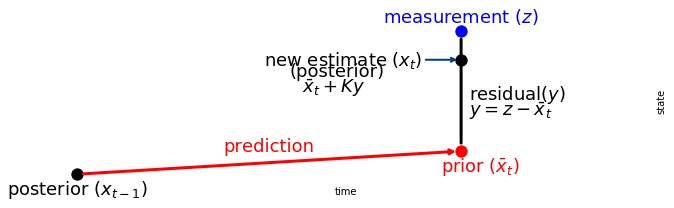

In [22]:
book_plots.show_residual_chart()

We need to design $\mathbf H$ so that $\mathbf{H\bar x}$ yields a measurement. For this problem we have a sensor that measures position, so $\mathbf z$ will be a one variable vector:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$
The residual equation will have the form

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$
$\mathbf H$ has to be a 1x2 matrix for $\mathbf{Hx}$ to be 1x1. Recall that multiplying matrices $m\times n$ by $n\times p$ yields a $m\times p$ matrix.

We will want to multiply the position $x$ by 1 to get the corresponding measurement of the position. We do not need to use velocity to find the corresponding measurement so we multiply  $\dot x$ by 0.

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$
And so, for our Kalman filter we set

$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

In [23]:
H = np.array([[1., 0.]])

#### Design the Measurement

Design the Measurement
The measurement is implemented with $\mathbf z$, the measurement mean, and $\mathbf R$, the measurement covariance.

$\mathbf z$ is easy. it contains the measurement(s) as a vector. We have only one measurement, so we have:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$
If we have two sensors or measurements we'd have:

$$\mathbf z = \begin{bmatrix}z_1 \\ z_2\end{bmatrix}$$
The measurement noise matrix models the noise in our sensors as a covariance matrix. In practice this can be difficult. A complicated system may have many sensors, the correlation between them might not be clear, and usually their noise is not a pure Gaussian. For example, a sensor might be biased to read high if the temperature is high, and so the noise is not distributed equally on both sides of the mean. We will learn to deal with these problems later.

The Kalman filter equations uses a covariance matrix $\mathbf R$ for the measurement noise. The matrix will have dimension $m{\times}m$, where $m$ is the number of sensors. It is a covariance matrix to account for correlations between the sensors. We have only 1 sensor so R is:

$$R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$
If $\sigma^2_z$ is 5 meters squared we'd have $R = \begin{bmatrix}5\end{bmatrix}$.

If we had two position sensors, the first with a variance of 5 m$^2$, the second with a variance of 3 m$^2$, we would write

$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$
We put the variances on the diagonal because this is a covariance matrix, where the variances lie on the diagonal, and the covariances, if any, lie in the off-diagonal elements. Here we assume there is no correlation in the noise between the two sensors, so the covariances are 0.

For our problem we only have one sensor, so we can implement this as

In [24]:
R = np.array([[5.]])

We perform the update by calling ```update```.

In [25]:
from filterpy.kalman import update
z = 1.
x, P = update(x, P, z, R, H)
print('x =', x)

x = [ 1.08532828 -0.63974876]


## 3. Implementing the Kalman Filter

First we construct a KalmanFilter object. We have to specify the number of variables in the state with the dim_x parameter, and the number of measurements with dim_z. We have two random variables in the state and one measurement, so we write:
```python
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
```
This creates an object with default values for all the Kalman filter matrices:

In [26]:
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', dog_filter.x.T)
print('R = ', dog_filter.R)
print('Q = \n', dog_filter.Q)
# etc...

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


Now we initialize the filter's matrices and vectors with values valid for our problem. I've put this in a function to allow you to specify different initial values for ```R```, ```P```, and ```Q``` and put it in a helper function. We will be creating and running many of these filters, and this saves us a lot of headaches.

In [27]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

```KalmanFilter``` initializes ```R```, ```P```, and ```Q``` to the identity matrix, so ```kf.P *= P``` is one way to quickly assign all of the diagonal elements to the same scalar value. Now we create the filter:

In [28]:
dt = .1
x = np.array([0., 0.]) 
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

In [29]:
from kf_book.mkf_internal import plot_track

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, 
                   dt=dt, **kwargs)
    return xs, cov

Let's run it. We have 50 measurements with a noise variance of 10 and a process variance of 0.01.

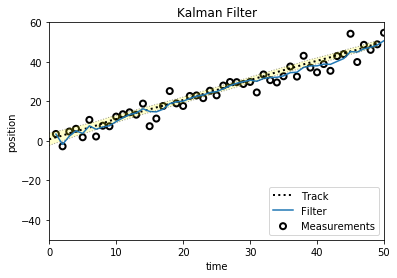

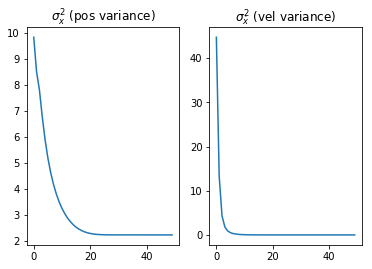

In [30]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

Here is a 3D plot showing the Gaussians every 7th epoch (time step). Every 7th separates them enough so can see each one independently. The first Gaussian at $t=0$ is to the left.

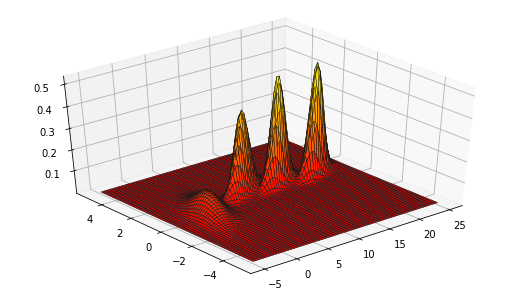

In [31]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_gaussians

P = np.diag([3., 1.])
np.random.seed(3)
Ms, Ps = run(count=25, R=10, Q=0.01, P=P, do_plot=False)
with figsize(x=9, y=5):
    plot_gaussians(Ms[::7], Ps[::7], (-5,25), (-5, 5), 75)